In [1]:
#!/usr/bin/env python

# Plots_changes_during_maxPR.ipynb

In [2]:
'''File name: Plots_changes_during_maxPR.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 19.05.2022
    Date last modified: 19.05.2022

    ############################################################## 
    Needs data from:
    papers/2021_Hist-Ext-PR-Changes/programs/Scaling_Changes/Peak_PR_Conditions/Peak_PR_contidions.py
    
    Purpos:

    - Read in peak annual hourly precipitation data (each event is at least 24-hours appart)
    - Read in other variables to see hot those are changing
    - Plot results on maps

'''

'File name: Plots_changes_during_maxPR.ipynb\n    Author: Andreas Prein\n    E-mail: prein@ucar.edu\n    Date created: 19.05.2022\n    Date last modified: 19.05.2022\n\n    ############################################################## \n    Needs data from:\n    papers/2021_Hist-Ext-PR-Changes/programs/Scaling_Changes/Peak_PR_Conditions/Peak_PR_contidions.py\n    \n    Purpos:\n\n    - Read in peak annual hourly precipitation data (each event is at least 24-hours appart)\n    - Read in other variables to see hot those are changing\n    - Plot results on maps\n\n'

In [3]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob
import os
from pdb import set_trace as stop
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import median_filter
from scipy.ndimage import label
from matplotlib import cm
from scipy import ndimage
import random
import scipy
import pickle
import datetime
import pandas as pd
import subprocess
from calendar import monthrange
import pandas as pd
import datetime
import sys 
import shapefile as shp
import matplotlib.path as mplPath
from scipy.stats import norm
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
from calendar import monthrange
from tqdm import tqdm
import xarray as xr

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
from matplotlib.colors import LogNorm
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cf

from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

#### speed up interpolation
import scipy.interpolate as spint
import scipy.spatial.qhull as qhull
import numpy as np

def interp_weights(xy, uv,d=2):
    tri = qhull.Delaunay(xy)
    simplex = tri.find_simplex(uv)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uv - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

def interpolate(values, vtx, wts):
    return np.einsum('nj,nj->n', np.take(values, vtx), wts)

def deiscretice_timeseries(DATA,
                          bucked_size):
#     Discrete_timeseries = np.copy(DATA); Discrete_timeseries[:] = np.nan
#     for tt in range(len(DATA)):
#         if ~np.isnan(DATA[tt]) == True:   
#             INT, REST = divmod(DATA[tt], bucked_size)
#             Discrete_timeseries[tt] = INT * bucked_size
#             if tt != len(DATA)-1:
#                 DATA[tt+1] = DATA[tt+1]+REST
#     return Discrete_timeseries

    if len(DATA.shape) == 1:
        # make data 2D
        DATA = DATA[:,None]
    Discrete_timeseries = np.copy(DATA); Discrete_timeseries[:] = np.nan
    for tt in tqdm(range(DATA.shape[0])):
        INT, REST = np.apply_along_axis(np.divmod, 0, DATA[tt,:], bucked_size)
        FIN = ~np.isnan(INT)
        Discrete_timeseries[tt,:] = INT * bucked_size
        if tt != len(DATA)-1:
            DATA[tt+1,FIN] = DATA[tt+1,FIN]+REST[FIN]
    return Discrete_timeseries

In [4]:
# ================================
# BUKOFSKY REGION
# Add the subregions
import geopandas as gpd
from tqdm import tqdm

REGIONS = [ 'Appalachia.shp',
            'CPlains.shp',
            'DeepSouth.shp',
            'GreatBasin.shp',
            'GreatLakes.shp',
            'Mezquital.shp',
            'MidAtlantic.shp',
            'NorthAtlantic.shp',
            'NPlains.shp',
            'NRockies.shp',
            'PacificNW.shp',
            'PacificSW.shp',
            'Prairie.shp',
            'Southeast.shp',
            'Southwest.shp',
            'SPlains.shp',
            'SRockies.shp']

REGIONS_names = [ 'Appalachia',
            'Central Plains',
            'Deep South',
            'Great Basin',
            'Great Lakes',
            'Mezquital',
            'Mid-Atlantic',
            'North-Atlantic',
            'Northern Plains',
            'Northern Rockies',
            'Pacific Northwest',
            'Pacific Southwest',
            'Prairie',
            'Southeast',
            'Southwest',
            'Southern Plains',
            'Southern Rockies']

In [5]:
##############################################################
#                READ CONUS404 CONSTANT FIELDS
sLon='XLONG'
sLat='XLAT'
sOro='HGT'
sLSM='LANDMASK'
sPlotDir = ''
GEO_EM_D1 = '/glade/campaign/ncar/USGS_Water/CONUS404/wrfconstants_d01_1979-10-01_00:00:00.nc4'

ncid=Dataset(GEO_EM_D1, mode='r') # open the netcdf
Lon=np.squeeze(ncid.variables[sLon][:])
Lat=np.squeeze(ncid.variables[sLat][:])
Height4=np.squeeze(ncid.variables[sOro][:])
LSM=np.squeeze(ncid.variables[sLSM][:])
ncid.close()

In [6]:
DataFolder = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/'
SaveFolder = '/glade/campaign/mmm/c3we/prein/CONUS404/data/CONUS404_processed_data/'

StartDay = datetime.datetime(1980, 1, 1, 0)
StopDay = datetime.datetime(2019, 12, 31, 23)
TimeHH = pd.date_range(StartDay, end=StopDay, freq='1h')
TimeMM = pd.date_range(StartDay, end=StopDay, freq='M')
Years = np.unique(TimeMM.year)

se=0
# Seasons = ['annual','DJF','MAM','JJA','SON']
# rgiSeasons = [range(1,13,1),
#                  [1,2,12],
#                  [3,4,5],
#                  [6,7,8],
#                  [9,10,11]]
Seasons = ['MJJASO','May-Jun','Jul-Aug','Sep-Oct']
rgiSeasons = [[5,6,7,8,9,10],
                 [5,6],
                 [7,8],
                 [9,10]]

dry_threshold = 0.1 # mm/h

variables = ['TD2', "totalVap", "MLLCL", "MLCINH", "MLCAPE",'PR']
vars_names = [['dewpoint temperature', '$^{\circ}$C'],
             ['precipitable water', 'mm'],
             ['lifting condensation level', 'm'],
             ['CIN','J kg$^{-1}$'],
             ['CAPE','J kg$^{-1}$'],
             ['extr. PR', 'mm h$^{-1}$']]

top_events = 10 # get 10 most extreme hourly pr events per grid cell

In [7]:
MaskFile = 'Burkofski_Regions_CONUS404.npz'
if os.path.exists(MaskFile) == False:
    rgiStatsInBasins = []
    MaskStations = np.zeros((Lon.shape[0],Lon.shape[1])); MaskStations[:] = np.nan
    rgrGridCells=[(Lon.flatten()[ii],Lat.flatten()[ii]) for ii in range(len(Lon.flatten()))]
    for re in tqdm(range(len(REGIONS))):
        data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
        Coordinates = data['geometry']
        for sf in range(len(data)):
            TEST = np.array(Coordinates[sf].exterior.coords.xy)
            ctr=TEST.T
            grPRregion=mplPath.Path(ctr)
            TMP=np.array(grPRregion.contains_points(rgrGridCells))
        TMP = np.reshape(TMP, (Lon.shape[0], Lon.shape[1]))
        MaskStations[TMP==1] = re+1
    #     MaskStations = np.append(MaskStations,[re+1]*len(iStationSelect))
    MaskStations = MaskStations.astype('int')
    
    np.savez(MaskFile,
            MaskStations = MaskStations,
            Lon = Lon,
            Lat = Lat)
else:
    DATA = np.load(MaskFile)
    MaskStations = DATA['MaskStations']
    Lon = DATA['Lon']
    Lat = DATA['Lat']
MaskStations[MaskStations < 0] = 0

Region_indices = ndimage.find_objects(MaskStations)
# Region_indices = ndimage.find_objects(MaskStations)

### Read annual peak events and pre-event environments

In [8]:
var_at_peak_pr = np.zeros((len(Years), top_events, len(variables), Lon.shape[0], Lon.shape[1])); var_at_peak_pr[:] = np.nan
for yy in range(len(Years)):
    for va in range(len(variables)-1):
        try:
            DATA = np.load('/glade/campaign/mmm/c3we/prein/CONUS404/data/CONUS404_processed_data//pr_vs_VARS/'+
                           str(Years[yy])+'_'+Seasons[se]+'_pr-vs-'+variables[va]+'_gridcells.npz')
            var_at_peak_pr[yy,:,va,:,:] = DATA['VAR_extr']
            if va == 0:
                var_at_peak_pr[yy,:,variables.index('PR'),:,:] = DATA['pr_extr']
        except:
            print('    missing '+variables[va]+' '+str(Years[yy]))


### Calculate linear trend estimates for dependent variables

In [9]:
# Calculate trends in dry hours
linear_trends_mean = np.zeros((len(variables), Lon.shape[0],Lon.shape[1], 5)); linear_trends_mean[:] = np.nan
annual_means = np.mean(var_at_peak_pr, axis=1)
for va in range(len(variables)):
    print('work on '+variables[va])
    for la in tqdm(range(Lon.shape[0])):
        for lo in range(Lon.shape[1]):
            linear_trends_mean[va,la,lo,:] = stats.linregress(Years, annual_means[:,va,la,lo])


  0%|          | 0/1015 [00:00<?, ?it/s]

work on TD2


  0%|          | 0/1015 [00:00<?, ?it/s]

work on totalVap


  0%|          | 0/1015 [00:00<?, ?it/s]

work on MLLCL


  0%|          | 0/1015 [00:00<?, ?it/s]

work on MLCINH


  0%|          | 0/1015 [00:00<?, ?it/s]

work on MLCAPE


  0%|          | 0/1015 [00:00<?, ?it/s]

work on PR


100%|██████████| 1015/1015 [05:30<00:00,  3.07it/s]


In [10]:
# Define color tables
colors_abs = ['#ffffff','#afdbef','#5a96c6','#64ab5f','#eadf6d','#e9813d','#c93d35','#962722',
              '#7a0177','#c51b8a','#f768a1','#fa9fb5','#fcc5c0']#,'#ea43f1']
CB = 50 # grid cells removed from boundary
trend_col = ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#f7f7f7','#d1e5f0','#92c5de','#4393c3','#2166ac','#053061'][::-1]


In [11]:
# ncfile = Dataset(GEO_EM_D1)
# HGT_M = getvar(ncfile, "HGT")
# cart_proj = get_cartopy(HGT_M)
# ncid.close()

# from matplotlib import colors as c


# fig = plt.figure(figsize=(12,25))
# rgsLableABC=list(string.ascii_lowercase)
# plt.rcParams.update({'font.size': 13})
# gs1 = gridspec.GridSpec(6,2)
# gs1.update(left=0.01, right=0.99,
#            bottom=0.06, top=0.98,
#            wspace=0.1, hspace=0.1)

# for va in range(len(variables)):
#     if variables[va] == 'TD2':
#         DATA = np.mean(annual_means[:,va,:,:], axis=0) -273.15
#         levels = np.linspace(0,25,len(colors_abs))
#         levels_trends = np.linspace(-1,1,len(trend_col))
#         TRENDS = linear_trends_mean[va,:,:,0]
#         trend_col_va = trend_col[::-1]
#         col_va = colors_abs
#     if variables[va] == 'totalVap':
#         DATA = np.mean(annual_means[:,va,:,:], axis=0)
#         levels = np.linspace(10,60,len(colors_abs))
#         levels_trends = np.linspace(-2,2,len(trend_col))
#         TRENDS = linear_trends_mean[va,:,:,0]
#         trend_col_va = trend_col[::-1]
#         col_va = colors_abs
#     if variables[va] == 'MLLCL':
#         DATA = np.mean(annual_means[:,va,:,:], axis=0)
#         levels = np.linspace(400,1400,len(colors_abs))
#         levels_trends = np.linspace(-50,50,len(trend_col))
#         TRENDS = linear_trends_mean[va,:,:,0]
#         trend_col_va = trend_col
#         col_va = colors_abs
#     if variables[va] == 'MLCINH':
#         DATA = np.mean(annual_means[:,va,:,:], axis=0)
#         levels = np.linspace(-100,0,len(colors_abs))
#         levels_trends = np.linspace(-10,10,len(trend_col))
#         TRENDS = linear_trends_mean[va,:,:,0]
#         trend_col_va = trend_col
#         col_va = colors_abs[::-1]
#     if variables[va] == 'MLCAPE':
#         DATA = np.mean(annual_means[:,va,:,:], axis=0)
#         levels = np.linspace(0,1000,len(colors_abs))
#         levels_trends = np.linspace(-50,50,len(trend_col))
#         TRENDS = linear_trends_mean[va,:,:,0]
#         trend_col_va = trend_col
#         col_va = colors_abs
#     if variables[va] == 'PR':
#         DATA = np.mean(annual_means[:,va,:,:], axis=0)
#         levels = np.linspace(0,50,len(colors_abs))
#         levels_trends = np.linspace(-2,2,len(trend_col))
#         TRENDS = linear_trends_mean[va,:,:,0]
#         trend_col_va = trend_col[::-1]
#         col_va = colors_abs
    
#     # "MLLCL", "MLCINH", "MLCAPE"
    
#     # -------------------------
#     # plot absolute values
#     ax = plt.subplot(gs1[va,0], projection=cart_proj)
#     pos1 = ax.get_position()
#     cMap = c.ListedColormap(col_va)
#     cs = plt.pcolormesh(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], DATA[CB:-CB,CB:-CB], cmap=cMap, 
#                         norm = mpl.colors.BoundaryNorm(levels, ncolors=len(colors_abs)-1, clip=False),
#                         transform=ccrs.PlateCarree())
#     # cs = plt.contourf(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], dry_hour_freq_rel[CB:-CB,CB:-CB], levels = np.linspace(80,100,21), extend='both', cmap='coolwarm', transform=ccrs.PlateCarree())
# #     plt.contour(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], Height4[CB:-CB,CB:-CB], levels = (500, 2000), colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
#     ax.coastlines(color='#636363')
#     ax.add_feature(cf.BORDERS, edgecolor='#636363')
#     ax.add_feature(cf.STATES, lw=0.5, edgecolor='#636363')
#     plt.axis('off')
#     plt.title(r"$\bf{" + rgsLableABC[va*2] + ")}$ "+' '+vars_names[va][0])

#     # Plot bukofsky retions in addition
#     for re in range(len(REGIONS)):
#         data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
#         Coordinates = data['geometry']
#         for sf in range(len(data)):
#             TEST = np.array(Coordinates[sf].exterior.coords.xy)
#             TEST=TEST.T
#             plt.plot(TEST[:,0],TEST[:,1], lw=1, c='k', transform=ccrs.PlateCarree(), alpha=0.4)

#     CbarAx = axes([pos1.x0 + pos1.width +0.08, pos1.y0, 0.02, pos1.height])
#     cb = colorbar(cs, cax = CbarAx, orientation='vertical', extend='both')#, ticks=np.linspace(0,0.0015,41))
#     # cb.ax.set_xticklabels(LEVS,rotation=90)
#     cb.set_label(vars_names[va][0]+' ['+vars_names[va][1]+']', fontsize=12)     


#     # # -------------------------
#     # Plot linear trends
#     ax = plt.subplot(gs1[va,1], projection=cart_proj)
#     pos1 = ax.get_position()
#     cMap = c.ListedColormap(trend_col_va)

#     cs = plt.pcolormesh(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], TRENDS[CB:-CB,CB:-CB]*10, cmap=cMap, 
#                         norm = mpl.colors.BoundaryNorm(levels_trends, ncolors=len(levels_trends)-1, clip=False),
#                         transform=ccrs.PlateCarree())
# #     plt.contourf(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], linear_trends_mean[va,CB:-CB,CB:-CB,3], 
# #                  levels=[0,0.1, 1], hatches=['///', None], alpha=0, transform=ccrs.PlateCarree(), transform_first=True)

# #     # cs = plt.contourf(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], dry_hour_freq_rel[CB:-CB,CB:-CB], levels = np.linspace(80,100,21), extend='both', cmap='coolwarm', transform=ccrs.PlateCarree())
# #     plt.contour(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], Height4[CB:-CB,CB:-CB], levels = (500, 2000), 
# #                 colors='k', linewidths=0.5, transform=ccrs.PlateCarree(), transform_first=True)
#     ax.coastlines(color='#636363')
#     ax.add_feature(cf.BORDERS, edgecolor='#636363')
#     ax.add_feature(cf.STATES, lw=0.5, edgecolor='#636363')
#     plt.axis('off')
#     plt.title(r"$\bf{" + rgsLableABC[va*2+1] + ")}$ "+vars_names[va][0]+' trend')

#     # Plot bukofsky retions in addition
#     for re in range(len(REGIONS)):
#         data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
#         Coordinates = data['geometry']
#         for sf in range(len(data)):
#             TEST = np.array(Coordinates[sf].exterior.coords.xy)
#             TEST=TEST.T
#             plt.plot(TEST[:,0],TEST[:,1], lw=1, c='k', transform=ccrs.PlateCarree(), alpha=0.4)

# #     CbarAx = axes([pos1.x0, pos1.y0-0.02, pos1.width, 0.01])
#     CbarAx = axes([pos1.x0 + pos1.width +0.08, pos1.y0, 0.02, pos1.height])
#     cb = colorbar(cs, cax = CbarAx, orientation='vertical', extend='both')#, ticks=np.linspace(0,0.0015,41))
#     # cb.ax.set_xticklabels(LEVS,rotation=90)
#     cb.set_label(vars_names[va][0]+'\ntrend ['+vars_names[va][1]+' decade$^{-1}$]', fontsize=12)


# sPlotFile=sPlotDir
# sPlotName= 'CONUS404_changes_during_extrPR_mean.jpg'
# if os.path.isdir(sPlotFile) != 1:
#     subprocess.call(["mkdir","-p",sPlotFile])
# print( '        Plot map to: '+sPlotFile+sPlotName)
# fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)

### Work on daily max

In [12]:
# # Calculate trends in dry hours
# linear_trends_max = np.zeros((len(variables), Lon.shape[0],Lon.shape[1], 5)); linear_trends_max[:] = np.nan
# annual_maxs = var_at_peak_pr[:,0,:,:]
# for va in range(len(variables)):
#     print('work on '+variables[va])
#     for la in tqdm(range(Lon.shape[0])):
#         for lo in range(Lon.shape[1]):
#             linear_trends_max[va,la,lo,:] = stats.linregress(Years, annual_maxs[:,va,la,lo])

In [13]:
# ncfile = Dataset(GEO_EM_D1)
# HGT_M = getvar(ncfile, "HGT")
# cart_proj = get_cartopy(HGT_M)
# ncid.close()

# from matplotlib import colors as c


# fig = plt.figure(figsize=(12,21))
# rgsLableABC=list(string.ascii_lowercase)
# plt.rcParams.update({'font.size': 13})
# gs1 = gridspec.GridSpec(5,2)
# gs1.update(left=0.01, right=0.99,
#            bottom=0.06, top=0.98,
#            wspace=0.1, hspace=0.1)

# for va in range(len(variables)):
#     if variables[va] == 'TD2':
#         DATA = annual_maxs[0,va,:,:] -273.15
#         levels = np.linspace(0,25,len(colors_abs))
#         levels_trends = np.linspace(-1,1,len(trend_col))
#         TRENDS = linear_trends_max[va,:,:,0]
#         trend_col_va = trend_col[::-1]
#         col_va = colors_abs
#     if variables[va] == 'totalVap':
#         DATA = annual_maxs[0,va,:,:]
#         levels = np.linspace(10,60,len(colors_abs))
#         levels_trends = np.linspace(-2,2,len(trend_col))
#         TRENDS = linear_trends_max[va,:,:,0]
#         trend_col_va = trend_col[::-1]
#         col_va = colors_abs
#     if variables[va] == 'MLLCL':
#         DATA = annual_maxs[0,va,:,:]
#         levels = np.linspace(400,1400,len(colors_abs))
#         levels_trends = np.linspace(-50,50,len(trend_col))
#         TRENDS = linear_trends_max[va,:,:,0]
#         trend_col_va = trend_col
#         col_va = colors_abs
#     if variables[va] == 'MLCINH':
#         DATA = annual_maxs[0,va,:,:]
#         levels = np.linspace(-100,0,len(colors_abs))
#         levels_trends = np.linspace(-10,10,len(trend_col))
#         TRENDS = linear_trends_max[va,:,:,0]
#         trend_col_va = trend_col
#         col_va = colors_abs[::-1]
#     if variables[va] == 'MLCAPE':
#         DATA = annual_maxs[0,va,:,:]
#         levels = np.linspace(0,1000,len(colors_abs))
#         levels_trends = np.linspace(-50,50,len(trend_col))
#         TRENDS = linear_trends_max[va,:,:,0]
#         trend_col_va = trend_col
#         col_va = colors_abs
    
#     # "MLLCL", "MLCINH", "MLCAPE"
    
#     # -------------------------
#     # plot absolute values
#     ax = plt.subplot(gs1[va,0], projection=cart_proj)
#     pos1 = ax.get_position()
#     cMap = c.ListedColormap(col_va)
#     cs = plt.pcolormesh(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], DATA[CB:-CB,CB:-CB], cmap=cMap, 
#                         norm = mpl.colors.BoundaryNorm(levels, ncolors=len(colors_abs)-1, clip=False),
#                         transform=ccrs.PlateCarree())
#     # cs = plt.contourf(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], dry_hour_freq_rel[CB:-CB,CB:-CB], levels = np.linspace(80,100,21), extend='both', cmap='coolwarm', transform=ccrs.PlateCarree())
# #     plt.contour(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], Height4[CB:-CB,CB:-CB], levels = (500, 2000), colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
#     ax.coastlines(color='#636363')
#     ax.add_feature(cf.BORDERS, edgecolor='#636363')
#     ax.add_feature(cf.STATES, lw=0.5, edgecolor='#636363')
#     plt.axis('off')
#     plt.title(r"$\bf{" + rgsLableABC[va*2] + ")}$ "+' '+vars_names[va][0])

#     # Plot bukofsky retions in addition
#     for re in range(len(REGIONS)):
#         data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
#         Coordinates = data['geometry']
#         for sf in range(len(data)):
#             TEST = np.array(Coordinates[sf].exterior.coords.xy)
#             TEST=TEST.T
#             plt.plot(TEST[:,0],TEST[:,1], lw=1, c='k', transform=ccrs.PlateCarree(), alpha=0.4)

#     CbarAx = axes([pos1.x0 + pos1.width +0.08, pos1.y0, 0.02, pos1.height])
#     cb = colorbar(cs, cax = CbarAx, orientation='vertical', extend='both')#, ticks=np.linspace(0,0.0015,41))
#     # cb.ax.set_xticklabels(LEVS,rotation=90)
#     cb.set_label(vars_names[va][0]+' ['+vars_names[va][1]+']', fontsize=12)     


#     # # -------------------------
#     # Plot linear trends
#     ax = plt.subplot(gs1[va,1], projection=cart_proj)
#     pos1 = ax.get_position()
#     cMap = c.ListedColormap(trend_col_va)

#     cs = plt.pcolormesh(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], TRENDS[CB:-CB,CB:-CB]*10, cmap=cMap, 
#                         norm = mpl.colors.BoundaryNorm(levels_trends, ncolors=len(levels_trends)-1, clip=False),
#                         transform=ccrs.PlateCarree())
# #     plt.contourf(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], linear_trends_max[va,CB:-CB,CB:-CB,3], 
# #                  levels=[0,0.1, 1], hatches=['///', None], alpha=0, transform=ccrs.PlateCarree(), transform_first=True)

# #     # cs = plt.contourf(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], dry_hour_freq_rel[CB:-CB,CB:-CB], levels = np.linspace(80,100,21), extend='both', cmap='coolwarm', transform=ccrs.PlateCarree())
# #     plt.contour(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], Height4[CB:-CB,CB:-CB], levels = (500, 2000), 
# #                 colors='k', linewidths=0.5, transform=ccrs.PlateCarree(), transform_first=True)
#     ax.coastlines(color='#636363')
#     ax.add_feature(cf.BORDERS, edgecolor='#636363')
#     ax.add_feature(cf.STATES, lw=0.5, edgecolor='#636363')
#     plt.axis('off')
#     plt.title(r"$\bf{" + rgsLableABC[va*2+1] + ")}$ "+vars_names[va][0]+' trend')

#     # Plot bukofsky retions in addition
#     for re in range(len(REGIONS)):
#         data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
#         Coordinates = data['geometry']
#         for sf in range(len(data)):
#             TEST = np.array(Coordinates[sf].exterior.coords.xy)
#             TEST=TEST.T
#             plt.plot(TEST[:,0],TEST[:,1], lw=1, c='k', transform=ccrs.PlateCarree(), alpha=0.4)

# #     CbarAx = axes([pos1.x0, pos1.y0-0.02, pos1.width, 0.01])
#     CbarAx = axes([pos1.x0 + pos1.width +0.08, pos1.y0, 0.02, pos1.height])
#     cb = colorbar(cs, cax = CbarAx, orientation='vertical', extend='both')#, ticks=np.linspace(0,0.0015,41))
#     # cb.ax.set_xticklabels(LEVS,rotation=90)
#     cb.set_label(vars_names[va][0]+'\ntrend ['+vars_names[va][1]+' decade$^{-1}$]', fontsize=12)


# sPlotFile=sPlotDir
# sPlotName= 'CONUS404_changes_during_extrPR_max.jpg'
# if os.path.isdir(sPlotFile) != 1:
#     subprocess.call(["mkdir","-p",sPlotFile])
# print( '        Plot map to: '+sPlotFile+sPlotName)
# fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)

### Trends in regions

In [14]:
REGIONS_names

['Appalachia',
 'Central Plains',
 'Deep South',
 'Great Basin',
 'Great Lakes',
 'Mezquital',
 'Mid-Atlantic',
 'North-Atlantic',
 'Northern Plains',
 'Northern Rockies',
 'Pacific Northwest',
 'Pacific Southwest',
 'Prairie',
 'Southeast',
 'Southwest',
 'Southern Plains',
 'Southern Rockies']

North-Atlantic
[3.9437299  2.49794227 1.90658416 1.5881252  1.35239209 1.18478021
 1.09994886 1.00450515 0.9600246  0.89405141]
[3.59135492 4.09245066 4.27724866 4.45000143 4.52632851 4.62287731
 4.71967016 4.77562244 4.87005169 4.96932061]
Northern Plains
[8.04164103 4.47250554 2.68138907 1.9344978  1.52031824 1.30291678
 1.15941907 1.04384291 0.94910417 0.89759671]
[7.58074198 8.74063775 8.89204209 8.88147424 8.88315433 8.94471321
 9.09586953 9.22139257 9.37428862 9.50823527]
Southeast
[3.51545492 3.92835018 4.28938054 4.50315762 4.7407903  4.79295856
 4.61311946 4.5830857  4.32140951 4.12689643]
[0.99636509 1.2365821  1.4316242  1.64010835 1.82340113 1.97699895
 2.14790434 2.33504575 2.45272678 2.62307952]
        Plot map to: PR-changes_depenent-on-environment-extreme.pdf


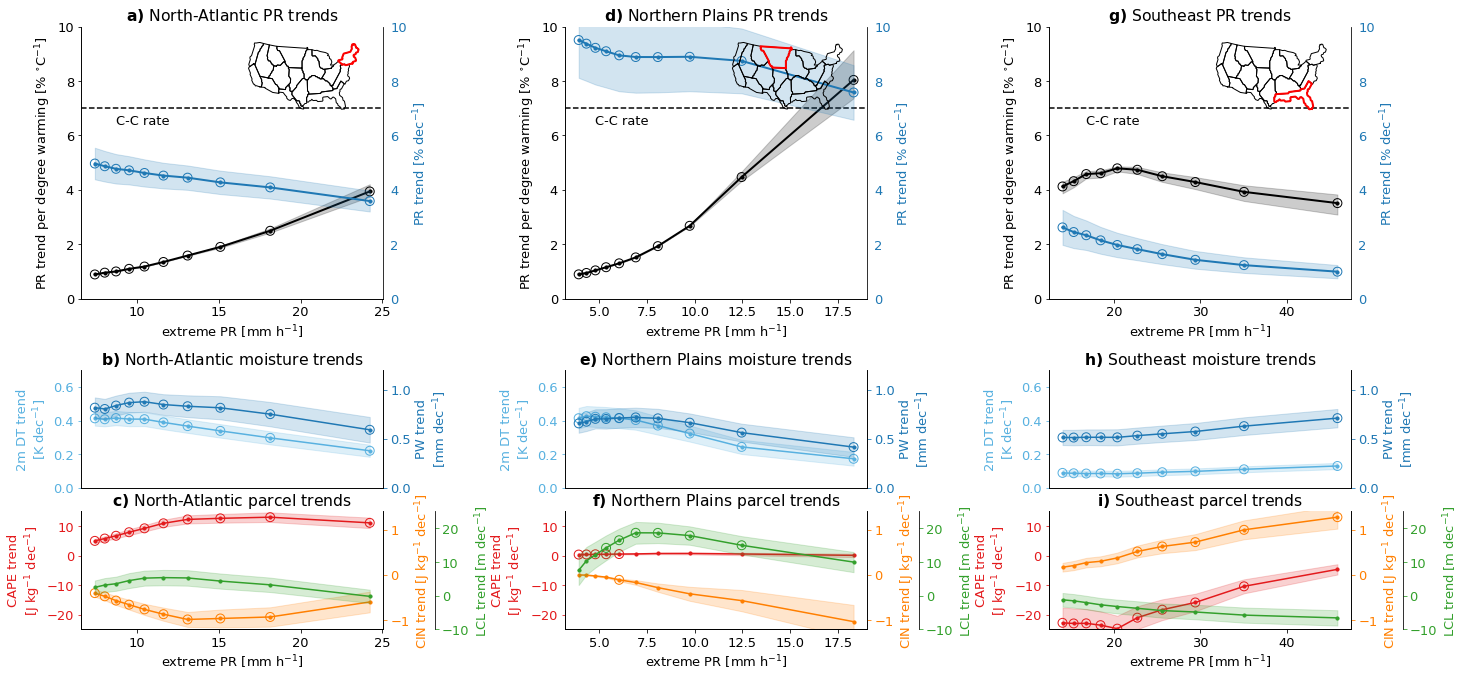

In [18]:
focus_regions = ['North-Atlantic', 'Northern Plains', 'Southeast'] #'Deep South']
fig = plt.figure(figsize=(18,9))
rgsLableABC=list(string.ascii_lowercase)
plt.rcParams.update({'font.size': 13})

for reg in range(len(focus_regions)):
    REGION = focus_regions[reg]
    re = REGIONS_names.index(REGION)
    va = 5

    gs1 = gridspec.GridSpec(1,3)
    gs1.update(left=0.01, right=0.99,
               bottom=0.56, top=0.98,
               wspace=0.6, hspace=0.5)

    print(REGIONS_names[re])

    reg_average = np.median(var_at_peak_pr[:,:,:,MaskStations == re+1], axis=3)
    trends = np.array([stats.linregress(Years, reg_average[:,ii,va]) for ii in range(10)])
    trendsDT = np.array([stats.linregress(Years, reg_average[:,ii,0]) for ii in range(10)])
    trendsPW = np.array([stats.linregress(Years, reg_average[:,ii,1]) for ii in range(10)])
    trendsLCL = np.array([stats.linregress(Years, reg_average[:,ii,2]) for ii in range(10)])
    trendsCIN = np.array([stats.linregress(Years, reg_average[:,ii,3]) for ii in range(10)])
    trendsCAPE = np.array([stats.linregress(Years, reg_average[:,ii,4]) for ii in range(10)])
    
#     # scaling rate calculation
#     from scipy.optimize import curve_fit
#     def func(x, li, sc):
#         return li * (1+sc)**x
#     peak_x = reg_average[:,:,0]
#     peak_y = reg_average[:,:,5]
#     scaling_rate = np.zeros((peak_x.shape[1])); scaling_rate[:] = np.nan
#     scaling_rate_std = np.copy(scaling_rate)
#     for ii in range(peak_x.shape[1]):
#         try:
#             popt, pcov = curve_fit(func, peak_x[:,ii], peak_y[:,ii], maxfev=8000, p0 = [22,0.1])
#             perr = np.sqrt(np.diag(pcov))
#             scaling_rate[ii] = popt[1]*100
#             scaling_rate_std[ii] = perr[1]*100
#         except:
#             continue

    # precipitation changes
    # plt.plot(trends[:,0]*10)
    ax = plt.subplot(gs1[:,reg])
    # plt.plot(np.mean(reg_average[:,:,5], axis=0), ((trends[:,0]/np.mean(reg_average[:,:,va], axis=0))*100)/(trendsDT[:,0]), 
    #          label='PR trend vs DT', c='k')
    plt.plot(np.mean(reg_average[:,:,5], axis=0), trends[:,0]/trendsDT[:,0], 
             label='PR trend vs DT', c='k', lw = 2)

#     plt.fill_between(np.mean(reg_average[:,:,5], axis=0), 
#                      scaling_rate + scaling_rate_std/2,
#                      scaling_rate - scaling_rate_std/2,
#                      color='#bdbdbd')
#     plt.plot(np.mean(reg_average[:,:,5], axis=0), scaling_rate, 
#              label='PR trend vs DT', c='k', lw=3)
    
    
    ax.set_ylabel('PR trend per degree warming [% $^{\circ}$C$^{-1}$]', color='k')
    ax.tick_params(axis='y', colors='k')
    ax.scatter(np.mean(reg_average[:,:,5], axis=0), trends[:,0]/trendsDT[:,0], color='k', s=10)
    print(trends[:,0]/trendsDT[:,0])
    
    SIG = trends[:,3] < 0.1
    ax.scatter(np.mean(reg_average[:,:,5], axis=0)[SIG], (trends[:,0]/trendsDT[:,0])[SIG], color='k', s=80, facecolor='none')
    plt.fill_between(np.mean(reg_average[:,:,5], axis=0), ((trends[:,0]+trends[:,4]/2)/(trendsDT[:,0]+trendsDT[:,4]/2)), ((trends[:,0]-trends[:,4]/2)/(trendsDT[:,0]-trendsDT[:,4]/2)),
                    color = 'k', alpha=0.2, zorder=0)
    plt.ylim([0,10])
    plt.axhline(y=7, color='k', linestyle='--')
    plt.text(np.mean(reg_average[:,:,5], axis=0)[7], 6.4, 'C-C rate', color='k')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax1 = ax.twinx()
    ax1.plot(np.mean(reg_average[:,:,5], axis=0), ((trends[:,0]/np.mean(reg_average[:,:,va], axis=0))*1000), 
             label='PR trend', color='#1f78b4', lw = 2)
    ax1.scatter(np.mean(reg_average[:,:,5], axis=0), ((trends[:,0]/np.mean(reg_average[:,:,va], axis=0))*1000), color='#1f78b4', s=10)
    SIG = trends[:,3] < 0.1
    ax1.scatter(np.mean(reg_average[:,:,5], axis=0)[SIG], (((trends[:,0]/np.mean(reg_average[:,:,va], axis=0))*1000))[SIG], color='#1f78b4', s=80, facecolor='none')
    print((((trends[:,0]/np.mean(reg_average[:,:,va], axis=0))*1000)))
    plt.fill_between(np.mean(reg_average[:,:,5], axis=0), (((trends[:,0]+trends[:,4]/2)/np.mean(reg_average[:,:,va], axis=0))*1000), 
                     (((trends[:,0]-trends[:,4]/2)/np.mean(reg_average[:,:,va], axis=0))*1000), color = '#1f78b4', alpha=0.2, zorder=0)
    ax1.set_ylabel('PR trend [% dec$^{-1}$]', color='#1f78b4')
    ax1.tick_params(axis='y', colors='#1f78b4')
    ax1.yaxis.set_ticks_position('none')
    ax1.xaxis.set_ticks_position('bottom')
    plt.ylim([0,10])
    ax.set_xlabel('extreme PR [mm h$^{-1}$]', color='k')
    ax1.spines['top'].set_visible(False)
    plt.title(r"$\bf{" + rgsLableABC[reg*3] + ")}$ "+REGIONS_names[re]+' PR trends')

    # add map that shows the region of interest
    import geopandas as gpd
    ncfile = Dataset('/glade/u/home/prein/projects/2020_CONUS404/programs/plots/Domain/geo_em.d01.nc')
    HGT_M = getvar(ncfile, "HGT_M")
    cart_proj = get_cartopy(HGT_M)
    ncid.close()
    pos1 = ax.get_position() # get the original position 
    pos2 = [pos1.x0 + 0.125, pos1.y0 + 0.26,  pos1.width / 2.5, pos1.height / 2.5]
    left, bottom, width, height = [0.25, 0.6, 0.2, 0.2]
    ax2 = fig.add_axes(pos2, projection=cart_proj)
    for rei in range(len(REGIONS)):
        data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[rei])
        Coordinates = data['geometry']
        for sf in range(len(data)):
            TEST = np.array(Coordinates[sf].exterior.coords.xy)
            TEST=TEST.T
            plt.plot(TEST[:,0],TEST[:,1], lw=1, c='k', transform=ccrs.PlateCarree(), alpha=1)
            if REGIONS_names[rei] == focus_regions[reg]:
                plt.plot(TEST[:,0],TEST[:,1], lw=2, c='r', transform=ccrs.PlateCarree(), alpha=1, zorder=10)
    plt.axis('off')
    
    
    ### Moisture and Parcel trends
    gs1 = gridspec.GridSpec(2,3)
    gs1.update(left=0.01, right=0.99,
               bottom=0.05, top=0.45,
               wspace=0.6, hspace=0.2)
    ### plot trends environmental moisture
    ax = plt.subplot(gs1[0,reg])
    col = '#58b1e0'
    plt.plot(np.mean(reg_average[:,:,5], axis=0), trendsDT[:,0]*10, c=col)
    plt.scatter(np.mean(reg_average[:,:,5], axis=0), trendsDT[:,0]*10, color=col, s=10)
    SIG = trendsDT[:,3] < 0.1
    plt.scatter(np.mean(reg_average[:,:,5], axis=0)[SIG], (trendsDT[:,0]*10)[SIG], color=col, s=80, facecolor='none')
    plt.fill_between(np.mean(reg_average[:,:,5], axis=0), trendsDT[:,0]*10-trendsDT[:,4]/2*10, trendsDT[:,0]*10+trendsDT[:,4]/2*10,
                    color = col, alpha=0.2, zorder=0)
    ax.set_ylabel('2m DT trend\n[K dec$^{-1}$]', color=col)
    ax.tick_params(axis='y', colors=col)
    # for ii in range(5):
    #     ax.text(np.mean(reg_average[:,:,5], axis=0)[ii],(trendsDT[:,0]*10)[ii], str(ii+1), color = '#a6cee3', ha='center', va='center')
    #     ax.plot(np.mean(reg_average[:,:,5], axis=0)[ii],(trendsDT[:,0]*10)[ii], 
    #             color = '#a6cee3', marker='o', markersize=20, fillstyle='none')
    plt.ylim([0,0.7])
    ax.axes.xaxis.set_visible(False)
    ax.spines['top'].set_visible(False)
    ax1 = ax.twinx()

    ax1.plot(np.mean(reg_average[:,:,5], axis=0), trendsPW[:,0]*10, c='#1f78b4', label='PW trend')
    ax1.scatter(np.mean(reg_average[:,:,5], axis=0), trendsPW[:,0]*10, color='#1f78b4', s=10)
    SIG = trendsPW[:,3] < 0.1
    ax1.scatter(np.mean(reg_average[:,:,5], axis=0)[SIG], (trendsPW[:,0]*10)[SIG], color='#1f78b4', s=80, facecolor='none')
    plt.fill_between(np.mean(reg_average[:,:,5], axis=0), trendsPW[:,0]*10-trendsPW[:,4]/2*10, trendsPW[:,0]*10+trendsPW[:,4]/2*10,
                    color = '#1f78b4', alpha=0.2, zorder=0)
    ax1.set_ylabel('PW trend\n[mm dec$^{-1}$]', color='#1f78b4')
    # ax1.spines["right"].set_position(("axes", 1))
    ax1.tick_params(axis='y', colors='#1f78b4')
    ax1.spines["right"].set_position(("axes", 1))
    plt.ylim([0,1.2])
    ax1.spines['top'].set_visible(False)
    plt.title(r"$\bf{" + rgsLableABC[reg*3+1] + ")}$ "+REGIONS_names[re]+' moisture trends')

    ### Sounding trends
    ax = plt.subplot(gs1[1,reg])
    ax.plot(np.mean(reg_average[:,:,5], axis=0), trendsCAPE[:,0]*10, c='#e31a1c', label='CAPE trend')
    # ax.spines["right"].set_position(("axes", 1.3))
    ax.set_ylabel('CAPE trend\n[J kg$^{-1}$ dec$^{-1}$]', color='#e31a1c')
    ax.tick_params(axis='y', colors='#e31a1c')
    plt.ylim([0,np.nanmax(trendsCAPE[:,0]*10)])
    plt.scatter(np.mean(reg_average[:,:,5], axis=0), trendsCAPE[:,0]*10, color='#e31a1c', s=10)
    SIG = trendsCAPE[:,3] < 0.1
    plt.scatter(np.mean(reg_average[:,:,5], axis=0)[SIG], (trendsCAPE[:,0]*10)[SIG], color='#e31a1c', s=80, facecolor='none')
    plt.fill_between(np.mean(reg_average[:,:,5], axis=0), trendsCAPE[:,0]*10-trendsCAPE[:,4]/2*10, trendsCAPE[:,0]*10+trendsCAPE[:,4]/2*10,
                    color = '#e31a1c', alpha=0.2, zorder=0)
    ax.spines['top'].set_visible(False)
    plt.ylim([-25,15])
    # CIN
    axCIN = ax.twinx()
    axCIN.plot(np.mean(reg_average[:,:,5], axis=0), trendsCIN[:,0]*10, c='#ff7f00', label='CIN trend')
    axCIN.spines["right"].set_position(("axes", 1))
    axCIN.set_ylabel('CIN trend [J kg$^{-1}$ dec$^{-1}$]', color='#ff7f00')
    axCIN.tick_params(axis='y', colors='#ff7f00')
    axCIN.scatter(np.mean(reg_average[:,:,5], axis=0), trendsCIN[:,0]*10, color='#ff7f00', s=10)
    SIG = trendsCIN[:,3] < 0.1
    axCIN.scatter(np.mean(reg_average[:,:,5], axis=0)[SIG], (trendsCIN[:,0]*10)[SIG], color='#ff7f00', s=80, facecolor='none')
    plt.fill_between(np.mean(reg_average[:,:,5], axis=0), trendsCIN[:,0]*10-trendsCIN[:,4]/2*10, trendsCIN[:,0]*10+trendsCIN[:,4]/2*10,
                    color = '#ff7f00', alpha=0.2, zorder=0)
    plt.ylim([-1.2,1.4])
    axCIN.spines['top'].set_visible(False)
    axLCL = ax.twinx()
    axLCL.plot(np.mean(reg_average[:,:,5], axis=0), trendsLCL[:,0]*10, c='#33a02c', label='LCL trend')
    axLCL.spines["right"].set_position(("axes", 1.17))
    axLCL.set_ylabel('LCL trend [m dec$^{-1}$]', color='#33a02c')
    axLCL.tick_params(axis='y', colors='#33a02c')
    axLCL.scatter(np.mean(reg_average[:,:,5], axis=0), trendsLCL[:,0]*10, color='#33a02c', s=10)
    SIG = trendsLCL[:,3] < 0.1
    axLCL.scatter(np.mean(reg_average[:,:,5], axis=0)[SIG], (trendsLCL[:,0]*10)[SIG], color='#33a02c', s=80, facecolor='none')
    plt.fill_between(np.mean(reg_average[:,:,5], axis=0), trendsLCL[:,0]*10-trendsLCL[:,4]/2*10, trendsLCL[:,0]*10+trendsLCL[:,4]/2*10,
                    color = '#33a02c', alpha=0.2, zorder=0)
    plt.ylim([-10, 25])
    ax.set_xlabel('extreme PR [mm h$^{-1}$]', color='k')
    axLCL.spines['top'].set_visible(False)
    plt.title(r"$\bf{" + rgsLableABC[reg*3+2] + ")}$ "+REGIONS_names[re]+' parcel trends')

sPlotFile=''
sPlotName= 'PR-changes_depenent-on-environment-extreme.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight', dpi=700)

--Call--
> /glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/IPython/core/displayhook.py(252)__call__()
    250         sys.stdout.flush()
    251 
--> 252     def __call__(self, result=None):
    253         """Printing with history cache management.
    254 



ipdb>  exit


BdbQuit: 

In [ ]:
# fit exponential curves to data to estimate scaling rates
scaling_rate = np.zeros((Lon.shape[0], Lon.shape[1])); scaling_rate[:] = np.nan
scaling_rate_std = np.copy(scaling_rate)

from scipy.optimize import curve_fit
def func(x, li, sc):
    return li * (1+sc)**x

pool = 0
for la in tqdm(range(pool, Lon.shape[0]-pool-1, 1)):
    for lo in range(pool, Lon.shape[1]-pool-1, 1):
        peak_x = var_at_peak_pr[:,0,0,la-pool:la+pool+1,lo-pool:lo+pool+1].flatten()
        peak_y = var_at_peak_pr[:,0,5,la-pool:la+pool+1,lo-pool:lo+pool+1].flatten()
        try:
            popt, pcov = curve_fit(func, peak_x, peak_y, maxfev=800, p0 = [22,0.07])
            perr = np.sqrt(np.diag(pcov))
            scaling_rate[la,lo] = popt[1]*100
            scaling_rate_std[la,lo] = perr[1]*100
        except:
            continue

In [ ]:
plt.contourf(Lon,Lat,scaling_rate, np.linspace(0,14,15), cmap='coolwarm', extend = 'both')

### Test using linear regression for the scaling analysis

In [ ]:
scaling_rate_lin = np.zeros((3, Lon.shape[0], Lon.shape[1], 5)); scaling_rate[:] = np.nan
pool = 5
for la in tqdm(range(pool, Lon.shape[0]-pool-1, 1)):
    for lo in range(pool, Lon.shape[1]-pool-1, 1):
        peak_x = np.mean(var_at_peak_pr[:,0,0,la-pool:la+pool+1,lo-pool:lo+pool+1], axis=(1,2))
        peak_y = np.mean(var_at_peak_pr[:,0,5,la-pool:la+pool+1,lo-pool:lo+pool+1], axis=(1,2))
        try:
            scaling_rate_lin[0,la,lo,:] = stats.linregress(Years,peak_x)
            scaling_rate_lin[1,la,lo,:] = stats.linregress(Years,peak_y)
            scaling_rate_lin[2,la,lo,0] = scaling_rate_lin[1,la,lo,1]/scaling_rate_lin[0,la,lo,0]
        except:
            continue

In [ ]:
ScalingRates = scaling_rate_lin[1,:,:,0]/scaling_rate_lin[0,:,:,0]
plt.pcolormesh(Lon,Lat,ScalingRates, vmin=-7, vmax = 7, cmap='coolwarm')



In [ ]:
np.median(ScalingRates[MaskStations == re+1])

In [ ]:
REGION = 'Southeast'
re = REGIONS_names.index(REGION)
va = 5
print(REGIONS_names[re])

reg_average = np.median(var_at_peak_pr[:,:,:,MaskStations == re+1], axis=3)

In [ ]:
reg_average.shape

In [ ]:
plt.scatter(reg_average[:,0,0], reg_average[:,0,5])
plt.show()
plt.plot(Years, reg_average[:,0,0])
plt.show()
plt.plot(Years, reg_average[:,0,5])
plt.show()

In [ ]:
DT_Trend = stats.linregress(Years,reg_average[:,0,0])
PR_trend = stats.linregress(Years,reg_average[:,0,5])
print(PR_trend[0]/DT_Trend[0])